# Your Name: Stephanie Buchanan

# import all packages 

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
import statsmodels.api as sm
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

# Data Prepocessing

Air pollution data, separately for summer and winter months
Description

Air pollution data from Leeds (U.K.) city centre, collected from 1994 to 1998. The summer data set corresponds to the months of April to July inclusive. The winter data set corresponds to the months of November to February inclusive. Some outliers have been removed, as discussed by Heffernan and Tawn, 2004.
Format

Data frames with 578 (summer) and 532 (winter) observations on the following 5 variables.

O3

    Daily maximum ozone in parts per billion.
NO2

    Daily maximum NO2 in parts per billion.
NO

    Daily maximum NO in parts per billion.
SO2

    Daily maximum SO2 in parts per billion.
PM10

    Daily maximum PM10 in micrograms/metre^3

Source

Provided as online supplementary material to Heffernan and Tawn, 2004:

http://www.blackwellpublishing.com/rss/Readmefiles/heffernan.htm 

In [2]:
summer = pd.read_csv('summer.csv', index_col= 0)
winter = pd.read_csv('winter.csv', index_col= 0)
pollution = pd.concat([summer, winter], axis=0)
len(summer), len(winter), len(pollution)

(578, 532, 1110)

In [3]:
#check for missing data
pollution.isnull().sum()

O3      0
NO2     0
NO      0
SO2     0
PM10    0
dtype: int64

In [4]:
#using robust scaling to deal with outliers
X = RobustScaler().fit_transform(pollution.values)

In [5]:
#Conduct a principal component analysis 
covar_matrix = PCA()
covar_matrix.fit(X)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=4)*100)
var #cumulative sum of variance explained with [n] features

array([ 51.38,  78.26,  90.42,  96.86, 100.  ])

The PCA analysis shows that three components captures 90.42% of the total variation of the data, and four captures 96.86%.  Therefore, three components were used in this analysis since it is easier to visualize three components on a plot and 90.42% of the data is still a very high percentage. 

In [6]:
mat_reduced = PCA(n_components=3).fit_transform(X)

#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ["PC1","PC2", "PC3"])


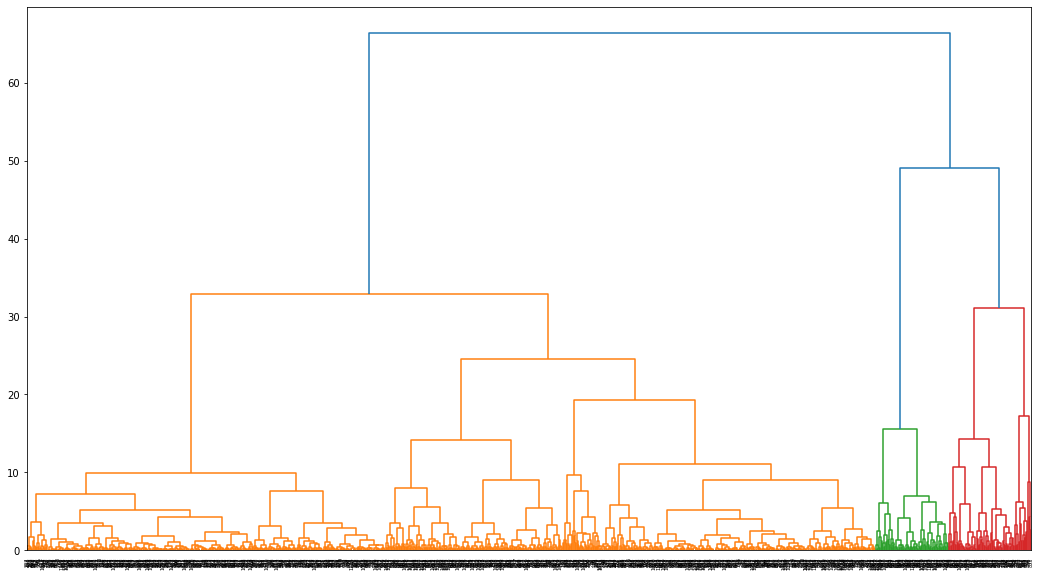

In [7]:
#Dendrogram to determine optimal number of clusters
plt.figure(figsize=(18, 10)) 
dendrogram = sch.dendrogram(sch.linkage(principal_df, method='ward'))

From the dendrogram, it looks like 3 is the optimal number of clusters.

In [8]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(principal_df)
labels = kmeans.predict(principal_df)
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

<IPython.core.display.Javascript object>


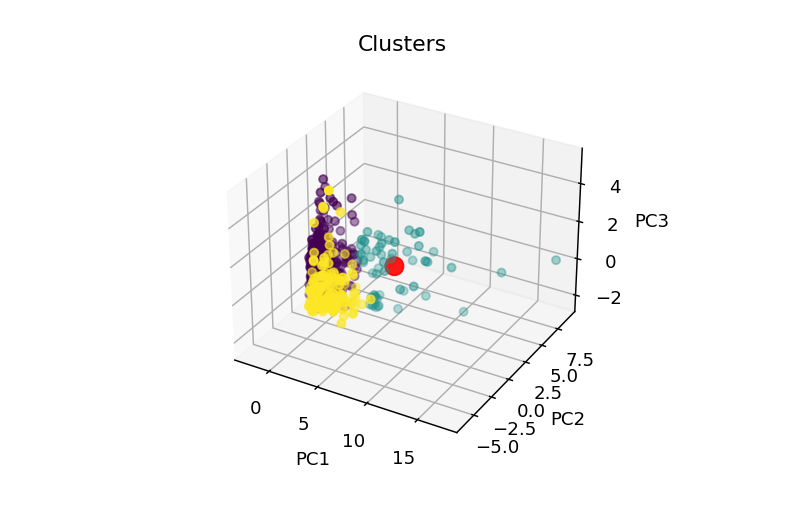

In [25]:
%matplotlib notebook
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining axes
z = principal_df['PC3']
x = principal_df['PC1']
y = principal_df['PC2']
centers = kmeans.cluster_centers_
ax.scatter(x, y, z, c = labels)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c = "red", s = 100, alpha = 0.9);
 
ax.set_title('Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [10]:
# Add Elbow plot
SSE = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(principal_df)
    SSE.append(kmeanModel.inertia_)

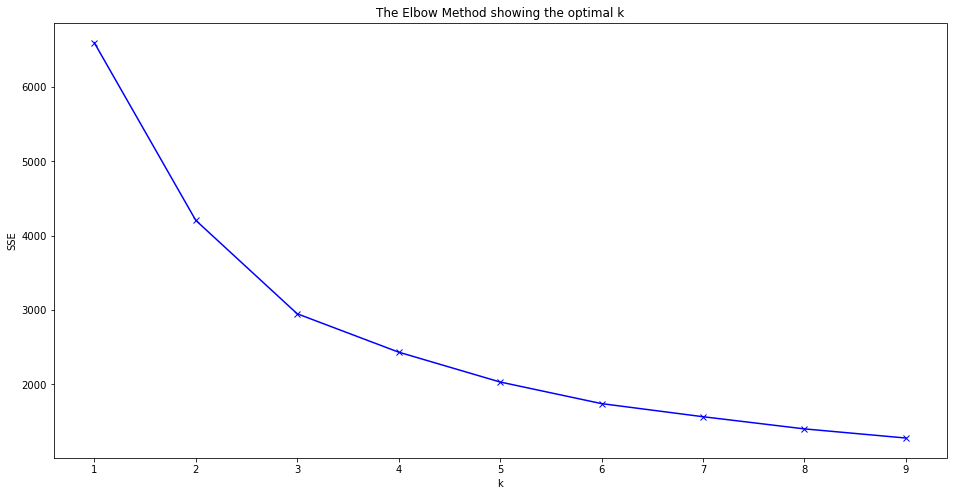

In [11]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
pollution['label'] = labels

# Data Splitting 

In [13]:
X_poll = pollution.drop('label', axis = 1).copy()
y_poll = pollution.label
#randomly split data into train and test dest
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_poll, y_poll, 
                                                        test_size=0.3, random_state= 42)

len(X_train1), len(y_train1), len(X_test1), len(y_test1)

(777, 777, 333, 333)

In [14]:
X_train1_sc = RobustScaler().fit_transform(X_train1)
X_test1_sc = RobustScaler().fit_transform(X_test1)

# Model Building and Evaluation 

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X_train1_sc, y_train1)

LogisticRegression()

In [16]:
y_pred_train1 = log_reg.predict(X_train1_sc)
y_pred_test1 = log_reg.predict(X_test1_sc)

In [17]:
# confusion matrix
cm = confusion_matrix(y_test1, y_pred_test1) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print(f'Train accuracy = {accuracy_score(y_train1, y_pred_train1):.4f}')
print(f'Test accuracy = {accuracy_score(y_test1, y_pred_test1):.4f}')

Confusion Matrix : 
 [[257   0   0]
 [  0  16   0]
 [  3   0  57]]
Train accuracy = 0.9910
Test accuracy = 0.9910


In [18]:
cs = np.linspace(.001, 1, num=20)
param_grid = {'C': cs}

grid_search = GridSearchCV(log_reg,
                           param_grid, cv=5,
                           scoring="accuracy",
                           return_train_score=True)

grid_search.fit(X_train1_sc, y_train1)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ])},
             return_train_score=True, scoring='accuracy')

In [19]:
grid_search.best_params_

{'C': 0.6845263157894736}

In [20]:
best = grid_search.best_estimator_

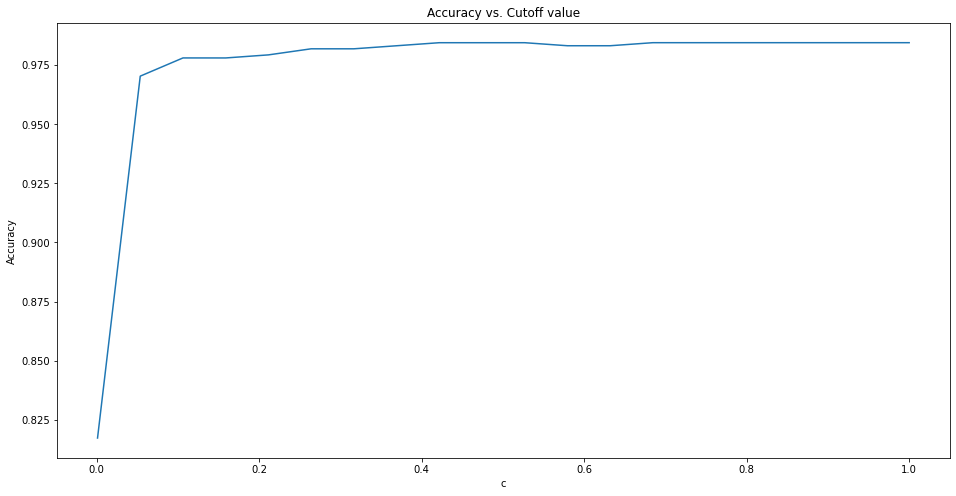

In [21]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(cs, grid_search.cv_results_['mean_test_score'])
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Cutoff value')
plt.show()

In [22]:
print(f'Train accuracy = {best.score(X_train1_sc, y_train1):.4f}')
print(f'Test accuracy = {best.score(X_test1_sc, y_test1):.4f}')

Train accuracy = 0.9897
Test accuracy = 0.9910


In [23]:
#looking at the variables in each cluster
cluster_0_df = pollution[pollution['label']==0]
cluster_1_df = pollution[pollution['label']==1]
cluster_2_df = pollution[pollution['label']==2]


print('Statistical Summary of Label 0 \n ----------\n\n', cluster_0_df.describe())
print('\nStatistical Summary of Label 1 \n ----------\n', cluster_1_df.describe())
print('\nStatistical Summary of Label 2 \n ----------\n', cluster_2_df.describe())

Statistical Summary of Label 0 
 ----------

                O3         NO2          NO         SO2       PM10  label
count  880.000000  880.000000  880.000000  880.000000  880.00000  880.0
mean    28.827273   38.056818   66.953409   11.401136   36.68750    0.0
std      9.877506    9.977059   41.681537    9.607508   17.08791    0.0
min      1.000000    9.000000    4.000000    0.000000    7.00000    0.0
25%     23.000000   31.000000   34.750000    5.000000   26.00000    0.0
50%     29.000000   38.000000   57.000000    9.000000   33.00000    0.0
75%     34.000000   45.000000   93.000000   15.000000   43.00000    0.0
max     84.000000   82.000000  204.000000   59.000000  185.00000    0.0

Statistical Summary of Label 1 
 ----------
               O3        NO2          NO         SO2       PM10  label
count  55.000000  55.000000   55.000000   55.000000   55.00000   55.0
mean   28.381818  43.418182   73.436364  106.727273   60.60000    1.0
std    16.976553  10.992743   52.505296   45.56820

In [24]:
print('\nStatistical Summary of summer \n ----------\n', summer.describe())
print('\nStatistical Summary of winter \n ----------\n', winter.describe())


Statistical Summary of summer 
 ----------
                O3         NO2          NO         SO2        PM10
count  578.000000  578.000000  578.000000  578.000000  578.000000
mean    31.996540   37.628028   55.200692   17.368512   41.122837
std     10.334777   11.861931   36.442750   29.264363   23.133486
min      8.000000    9.000000    4.000000    0.000000    9.000000
25%     26.000000   30.000000   30.000000    5.000000   26.000000
50%     31.000000   36.000000   47.000000    8.000000   34.000000
75%     36.000000   45.000000   71.750000   15.000000   50.000000
max     84.000000  105.000000  256.000000  313.000000  185.000000

Statistical Summary of winter 
 ----------
                O3         NO2          NO         SO2        PM10
count  532.000000  532.000000  532.000000  532.000000  532.000000
mean    20.056391   44.169173  135.456767   21.031955   48.441729
std     10.895870   11.286775  102.486911   20.950505   27.893839
min      1.000000   19.000000   10.000000    1.00000

# Conclusion 

Clustering is an unsupervised learning method that uses input data to group similar observations or cases into clusters. Principal Component Analysis (PCA) is a data reduction techinque.  This allows the subsequent analysis to be performed on only the principal components of the data instead of the whole data set.  This allows for more efficient analysis.

The summer and winter air pollution data from Leeds (U.K.) from 1994 to 1998 was first reduced to 3 variables using PCA.  A dedrogram showed the optimal number of clusters for the data is 3, and this number was confirmed in the elbow plot.  KMeans algorithm was then applied to produce labels for the data into 3 clusters.  The visualization of the clusters showed the centroids and how the clusters were separated.

After the labels were added to the data, the data was split into training and test sets, then fit to a logistic regression model.  The C parameter was tuned and the resulting accuracy score of the test set was 99.1%, which is very high.  This result indicates the clustering algorithm found good clusters that can be used for classification.

Observations in cluster 0 had high O3, moderate NO2, moderate NO, high SO2 and moderate PM10 levels. Observations in cluster 1 had high O3, low NO2, low NO, low SO2 and low PM10 levels. Observations in cluster 2 had low O3, high NO2, high NO, moderate SO2 and high PM10 levels.

These clusters are different from just the differences between summer and winter, so there may be another environmental factor that can be identified that influences air pollution in Leeds.  It could be related to holiday times with incoming traffic or maybe some chemical process that happens at different times.  A deeper understanding of how the levels of O3, NO2, NO, SO2 and PM10 are affected is needed for a true assessment of the clusters. 